In [1]:
!pip install unsloth -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.7/405.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 153.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.4/566.4 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re

from unsloth import FastLanguageModel, is_bfloat16_supported
from datasets import load_dataset, Dataset
from trl import SFTTrainer
from transformers import TrainingArguments, TextIteratorStreamer
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
from tqdm.auto import tqdm

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


# **Download Dataset**

In [3]:
dataset = load_dataset("dair-ai/emotion")

README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
train_dataset = dataset["train"].to_pandas()
test_dataset = dataset["test"].to_pandas()
val_dataset = dataset["validation"].to_pandas()

In [5]:
train_dataset.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [6]:
test_dataset.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,0
1,im updating my blog because i feel shitty,0
2,i never make her separate from me because i do...,0
3,i left with my bouquet of red and yellow tulip...,1
4,i was feeling a little vain when i did this one,0


In [7]:
val_dataset.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1


# **Load Model**

In [8]:
base_model = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
)

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.81G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

# **Transformed Dataset**

In [9]:
emotion_map = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

emotion_list = "['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']"

In [10]:
def create_question(text):
    return f"{text} You will be given a sentence. From the below list of emotions, \
    choose the emotion that the speaker can have while speaking the sentence. \
    {emotion_list} Respond with the emotion only."

def generate_cot(text, emotion):
    templates = {
        'sadness': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting words expressing sorrow or disappointment\n3. Negative sentiment with melancholic tone\n4. Emotion: sadness\n</think>",

        'joy': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting positive expressions and happiness\n3. Uplifting and cheerful sentiment\n4. Emotion: joy\n</think>",

        'love': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting affection and caring expressions\n3. Warm and positive sentiment\n4. Emotion: love\n</think>",

        'anger': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting aggressive or frustrated language\n3. Strong negative sentiment\n4. Emotion: anger\n</think>",

        'fear': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting anxiety or worry expressions\n3. Negative sentiment with uncertainty\n4. Emotion: fear\n</think>",

        'surprise': f"<think>\n1. Analyzing: '{text[:60]}...'\n2. Detecting unexpected information\n3. Expressions of astonishment\n4. Emotion: surprise\n</think>"
    }

    return templates.get(emotion, "")

In [11]:
def transform_data_train(data: pd.DataFrame) -> pd.DataFrame:
    transformed_data = pd.DataFrame(columns=['Question', 'Complex_CoT', 'Response'])

    transformed_data["Response"] = data["label"].apply(lambda x: emotion_map[x])
    transformed_data["Question"] = data["text"].apply(create_question)
    transformed_data["Complex_CoT"] = data.apply(
        lambda row: generate_cot(row["text"], emotion_map[row["label"]]),
        axis=1
    )

    return transformed_data

def mapping_response(data: pd.DataFrame) -> pd.DataFrame:
    data['label'] = data['label'].apply(lambda x: emotion_map[x])

    return data

In [12]:
transformed_train = transform_data_train(train_dataset).reset_index(drop=True)
transformed_test = mapping_response(test_dataset)
transformed_val = mapping_response(val_dataset)

In [13]:
transformed_test.head()

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [14]:
transformed_val.head()

,text,label
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


# **Train Model**

## **Prepare Dataset for Training**

In [49]:
prompt_style = """Below is an instruction that describes a task, paired with an input that provides
further context. Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step
chain of thoughts to ensure a logical and accurate response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker.
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

### Question:
{}

### Response:

Final Answer:
<Emotions>{}</Emotions>"""

In [50]:
train_prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker.
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

### Question:
{}

### Response:
{}

Final Answer:
<Emotions>{}</Emotions>"""

In [51]:
EOS_TOKEN = tokenizer.eos_token

In [52]:
def formatting_prompts_func(examples):
    questions = examples["Question"]
    cots = examples["Complex_CoT"]
    responses = examples["Response"]
    texts = []

    for question, cot, response in zip(questions, cots, responses):
        text = train_prompt_style.format(question, cot, response) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

train_dataset = Dataset.from_pandas(transformed_train)
train_dataset_modeling = train_dataset.map(formatting_prompts_func, batched=True)

print("\n📄 Sample formatted text:")
print(train_dataset_modeling["text"][0][:])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]


📄 Sample formatted text:
Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.
Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and emotionally insightful response.

### Instruction:
You are an expert in emotional intelligence and sentiment analysis.
Analyze the given sentence and identify the primary emotion expressed by the speaker. 
Choose only ONE emotion from the provided list: sadness, joy, love, anger, fear, surprise.

### Question:
i didnt feel humiliated You will be given a sentence. From the below list of emotions,     choose the emotion that the speaker can have while speaking the sentence.     ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'] Respond with the emotion only.

### Response:
<think>
1. Analyzing: 'i didnt feel humiliated...'
2. Detecting words expressing sorrow or disappointment
3. Neg

## **Setup LoRA PEFT**

In [42]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth: Already have LoRA adapters! We shall skip this step.


## **Setup Training Arguments**

In [43]:
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset_modeling,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,  # Effective batch = 8
        warmup_steps=10,
        num_train_epochs=1,  # Atau pakai max_steps
        max_steps=100,  # Alternatif: fixed steps
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        save_strategy="epoch",
        save_total_limit=2,
        report_to="none",
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/16000 [00:00<?, ? examples/s]

In [44]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 16,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,795,552,768 (1.03% trained)


Step,Training Loss
10,0.391300
20,0.351300
30,0.399000
40,0.360700
50,0.338800
60,0.348800
70,0.362400
80,0.325100
90,0.431300
100,0.366400


# **Create Prediction**

In [53]:
question = f"The clown's antics made everyone burst into laughter, completely forgetting the gloomy weather outside. You will be given a sentence. From the below list of emotions, choose the emotion that the speaker can have while speaking the sentence. {emotion_list} Respond with the emotion only."

FastLanguageModel.for_inference(model)  # Unsloth has 2x faster inference!
inputs = tokenizer([prompt_style.format(question, "")], return_tensors="pt").to("cuda")

outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=1200,

    use_cache=True,
)
response = tokenizer.batch_decode(outputs)

print(response[0].split("### Response:")[1])




Final Answer:
<Emotions></Emotions> <｜end▁of▁sentence｜>


# **Evaluate Model**

In [42]:
def create_question(text, emotion_list):
    question = f"{text} You will be given a sentence. From the below list of emotions, choose the emotion that the speaker can have while speaking the sentence. {emotion_list} Respond with the emotion only."
    return question

In [44]:
def extract_emotion(response_text, emotion_list):
    try:
        # Hapus tag XML dan special tokens
        cleaned = re.sub(r'<[^>]+>', '', response_text).strip()

        # Buat pattern regex
        pattern = r'\b(' + '|'.join(emotion_list) + r')\b'

        # Cari semua kemunculan
        matches = re.findall(pattern, cleaned, re.IGNORECASE)

        if matches:
            return matches[-1].lower()
        else:
            # Fallback: ambil kata terakhir
            words = cleaned.split()
            if words:
                last_word = words[-1].strip('.,;:!?').lower()
                if last_word in emotion_list:
                    return last_word
            return "unknown"
    except:
        return "unknown"

In [45]:
def predict_batch(texts, model, tokenizer, prompt_style, emotion_list, batch_size=8):
    predictions = []

    # Set model ke inference mode
    FastLanguageModel.for_inference(model)

    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i+batch_size]

        # Buat questions
        questions = [create_question(text, emotion_list) for text in batch_texts]

        # Format prompts
        prompts = [prompt_style.format(q, "") for q in questions]

        # Tokenize
        inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        # Generate
        outputs = model.generate(
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=200,
            use_cache=True,
        )

        # Decode
        responses = tokenizer.batch_decode(outputs, skip_special_tokens=False)

        # Extract emotions
        for response in responses:
            if "### Response:" in response:
                response_text = response.split("### Response:")[1]
            else:
                response_text = response

            emotion = extract_emotion(response_text, emotion_list)
            predictions.append(emotion)

    return predictions

In [46]:
texts = transformed_val['text'].tolist()
true_labels = transformed_val['label'].tolist()

# Predict
predictions = predict_batch(texts, model, tokenizer, prompt_style, emotion_list, batch_size=8)

# Save prediction to dataframe
transformed_val['predicted'] = predictions

Predicting:   0%|          | 0/250 [00:00<?, ?it/s]

In [47]:
def calculate_metrics(true_labels, predictions, emotion_list):
    # Filter unknown predictions
    valid_indices = [i for i, pred in enumerate(predictions) if pred != "unknown"]

    if len(valid_indices) == 0:
        print("No valid predictions")
        return None

    filtered_true = [true_labels[i] for i in valid_indices]
    filtered_pred = [predictions[i] for i in valid_indices]

    # Accuracy
    accuracy = accuracy_score(filtered_true, filtered_pred)

    # Precision, Recall, F1
    precision, recall, f1, support = precision_recall_fscore_support(
        filtered_true, filtered_pred, labels=emotion_list, average=None, zero_division=0
    )

    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        filtered_true, filtered_pred, average='macro', zero_division=0
    )

    # Confusion Matrix
    cm = confusion_matrix(filtered_true, filtered_pred, labels=emotion_list)

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': cm,
        'valid_count': len(valid_indices),
        'total_count': len(predictions),
        'unknown_count': len(predictions) - len(valid_indices)
    }

    return results

In [49]:
emotion_list = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

results = calculate_metrics(true_labels, predictions, emotion_list)

if results:
    print("="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    print(f"\nTotal samples: {results['total_count']}")
    print(f"Valid predictions: {results['valid_count']}")
    print(f"Unknown predictions: {results['unknown_count']}")
    print(f"\nOverall Accuracy: {results['accuracy']:.4f}")
    print(f"\nMacro Precision: {results['macro_precision']:.4f}")
    print(f"Macro Recall: {results['macro_recall']:.4f}")
    print(f"Macro F1-Score: {results['macro_f1']:.4f}")

    print("\n" + "="*60)
    print("PER-CLASS METRICS")
    print("="*60)
    print(f"{'Emotion':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<12}")
    print("-"*60)

    for i, emotion in enumerate(emotion_list):
        print(f"{emotion:<12} {results['precision'][i]:<12.4f} {results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} {results['support'][i]:<12}")

EVALUATION RESULTS

Total samples: 2000
Valid predictions: 1265
Unknown predictions: 735

Overall Accuracy: 0.0032

Macro Precision: 0.0677
Macro Recall: 0.0023
Macro F1-Score: 0.0041

PER-CLASS METRICS
Emotion      Precision    Recall       F1-Score     Support     
------------------------------------------------------------
sadness      1.0000       0.0060       0.0119       335         
joy          0.0000       0.0000       0.0000       432         
love         0.0000       0.0000       0.0000       115         
anger        0.0000       0.0000       0.0000       185         
fear         0.0000       0.0000       0.0000       144         
surprise     0.2857       0.0370       0.0656       54          


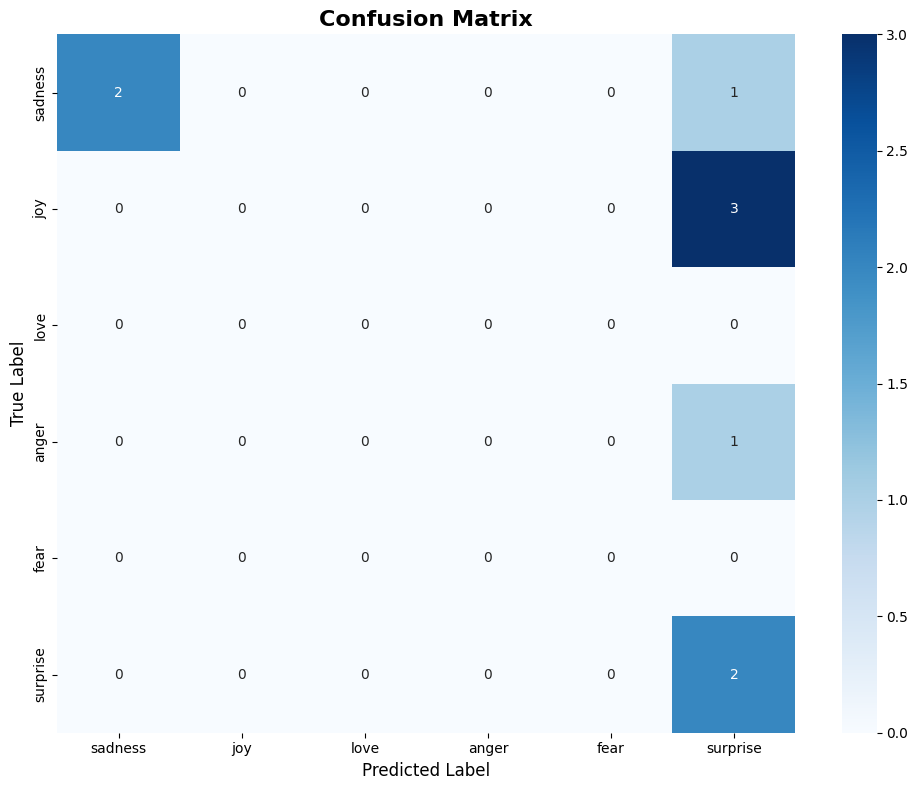

In [50]:
def plot_confusion_matrix(cm, emotion_list):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_list, yticklabels=emotion_list)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(results['confusion_matrix'], emotion_list)